In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import sys
import os
from zipfile import ZipFile
import csv
import random
from math import isnan 

In [2]:
scyjava.config.add_option('-Xmx30g')
#ij = imagej.init('/home/saka/fiji-linux64/Fiji.app', mode = 'interactive')
ij = imagej.init('/home/saka/sw/local/fiji/2023', mode='interactive')
ij.ui().showUI()
ij.getVersion()

'2.14.0/1.54f'

In [3]:
showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
Duplicator = scyjava.jimport('ij.plugin.Duplicator')()
ov = Overlay()
Model =  scyjava.jimport('fiji.plugin.trackmate.Model')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Logger= scyjava.jimport('fiji.plugin.trackmate.Logger')
DetectorKeys= scyjava.jimport('fiji.plugin.trackmate.detection.DetectorKeys') 
ExportTracksToXML= scyjava.jimport('fiji.plugin.trackmate.action.ExportTracksToXML') 
TmXmlWriter= scyjava.jimport('fiji.plugin.trackmate.io.TmXmlWriter')
LogRecorder = scyjava.jimport('fiji.plugin.trackmate.util.LogRecorder')
SparseLAPTrackerFactory= scyjava.jimport('fiji.plugin.trackmate.tracking.jaqaman.SparseLAPTrackerFactory')
TMUtils = scyjava.jimport('fiji.plugin.trackmate.util.TMUtils')
HyperStackDisplayer = scyjava.jimport('fiji.plugin.trackmate.visualization.hyperstack.HyperStackDisplayer')
SelectionModel = scyjava.jimport('fiji.plugin.trackmate.SelectionModel')
CellposeDetectorFactory = scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeDetectorFactory')
FeatureFilter = scyjava.jimport('fiji.plugin.trackmate.features.FeatureFilter')
DisplaySetting = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettings')
DisplaySettingsIO = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettingsIO')
CaptureOverlayAction = scyjava.jimport('fiji.plugin.trackmate.action.CaptureOverlayAction')
PretrainedModel= scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeSettings.PretrainedModel')
ThresholdDetectorFactory= scyjava.jimport('fiji.plugin.trackmate.detection.ThresholdDetectorFactory')
TrackScheme = scyjava.jimport('fiji.plugin.trackmate.visualization.trackscheme.TrackScheme')
TrackTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.TrackTableView')
AllSpotsTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.AllSpotsTableView')

rm = ij.RoiManager.getRoiManager()

In [4]:
def track_bacteria(bact, directory_path, dsettings, quality_filter, tsettings, display=False):
    '''
    This function leverages ImageJ's Trackmate plugin to track the bacteria within each single-cell video provided in the input folder bact. 
    It uses the Tresholding Detector for segmentation (with detection parameters specified in dsettings), and the LAP Tracker algorithm for tracking (with tracking parameters specified in tsettings). The function also takes as input the desired quality filter on the detected spots.
    The function saves the Trackmate XML model as well as a CSV file of the tracks for each cell in bact/Output/.
    '''
    out = bact_path+"Output/"
    if not os.path.exists(out):
        os.makedirs(out)
    for image in os.listdir(bact):
        if (image[len(image)-4:] == ".tif"):
            # Open Image
            imp = ij.IJ.openImage(bact + image)
            imp.show()
            ij.IJ.run("Smooth", "stack")
            ij.IJ.run("Smooth", "stack")
            # Create Model
            model = Model()
            settings = Settings(imp)
            # Detector
            settings.detectorFactory = ThresholdDetectorFactory()
            for parameter, value in dsettings.items():
                settings.detectorSettings[parameter] = value
            filter1 = FeatureFilter('QUALITY', quality_filter, True)
            settings.addSpotFilter(filter1)
            print(settings.detectorSettings)
            # Tracker
            settings.trackerFactory = SparseLAPTrackerFactory()
            settings.trackerSettings = settings.trackerFactory.getDefaultSettings()
            for parameter, value in tsettings.items():
                settings.trackerSettings[parameter] = value
            # Execute Tracking
            trackmate = TrackMate(model, settings)
            ok = trackmate.checkInput()
            if not ok:
                sys.exit(str(trackmate.getErrorMessage()))
            ok = trackmate.process()
            if not ok:
                sys.exit(str(trackmate.getErrorMessage()))
            selectionModel = SelectionModel(model)
            # Display
            ds = DisplaySettingsIO.readUserDefault()
            if display:
                displayer = HyperStackDisplayer(model, selectionModel, imp, ds)
                displayer.render()
                displayer.refresh()
                trackscheme = TrackScheme(model, selectionModel, ds)
                trackscheme.render()
            # Save Data
            basename_image = os.path.basename(image)
            corename = os.path.splitext(basename_image)[0]
            outFile = Path(out+corename+"_exportModel.xml")
            writer = TmXmlWriter(outFile)
            writer.appendModel(model)
            writer.appendSettings(settings)
            writer.writeToFile()
            csvFileSpots = out+corename+"_exportTracks.csv"
            spotsTableView = AllSpotsTableView(model, selectionModel, ds)
            spotsTableView.exportToCsv(csvFileSpots)
    ij.py.run_macro('close("*")')
    
def merge_trackmate_rois(bact_path, directory_path):
    '''
    This function seeks to assign bacterial ROIs to tracks by merging the results of tracking (via Trackmate) and ROI detection (via Thresholding in ImageJ). It matches ROIs to spots detected in Trackmate based on the nearest centroid.
    For each cell, the function saves a CSV file of tracks and their corresponding ROIs in a folder called grouped.
    '''
    file_pattern = os.path.join(bact_path, "*.tif")
    file_list = glob.glob(file_pattern)
    out = directory_path+"grouped/"
    if not os.path.exists(out):
        os.makedirs(out)
    for file_path in file_list:
        filename = os.path.basename(file_path)
        filename2 = os.path.splitext(filename)[0]
        first = Path(f"{bact_path}/Output/{filename2}_exportTracks.csv").as_posix()
        second = Path(f"{bact_path}/{filename2}_bactROI.csv").as_posix()
        pairwise = xref_locations(first, second, 
                              first_x='POSITION_X', 
                              first_y='POSITION_Y', 
                              first_z='POSITION_Z', 
                              second_x='X', 
                              second_y='Y', 
                              second_z='Slice', 
                              verbose=False)
        grouped = pairwise.groupby('ID', group_keys=False)[pairwise.columns[12]].apply(list).reset_index()
        grouped.rename(columns={'index_right': 'object_ID_list'}, inplace=True)
        final_csv = Path(f"{directory_path}/grouped/{filename2}_grouped.csv")
        grouped.to_csv(final_csv)
        final_csv2 = Path(f"{directory_path}/grouped/{filename2}_pairwise.csv")
        pairwise.to_csv(final_csv2)
    return out

def apply_bact_overlays(bact_path, grouped):
    '''
    This function allows for visual quality-control of the bacterial-tracking step by adding colored overlays to the bacterial tracks in each single-cell video. Bacterial clusters of the same track remain the same color from frame to frame.
    All of the overlayed videos are saved in the folder bact with the title [cell_number]_overlay.tif.
    '''
    file_pattern = os.path.join(bact_path, "*.tif")
    file_list = glob.glob(file_pattern)
    colors = ["blue", "cyan", "green", "magenta", "orange", "red", "yellow"]
    for file_path in file_list: # cycle through images, open them and open the matching "grouped' csv file
        imp = ij.IJ.openImage(file_path)
        ij.ui().show(imp)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        input_csv = Path(f"{grouped}/{f_name}_grouped.csv")
        df = pandas.read_csv(input_csv)
        pouet = df['object_ID_list']
        input_ROI = Path(f"{bact_path}/{f_name}_bactROI.zip")
        rm.open(f"{input_ROI}")
        for i in range(len(pouet)):
            single_row = df.iloc[i]
            random_color = random.choice(colors)
            row_cellids = single_row.object_ID_list
            row_cleaned = row_cellids.strip('[').strip(']')
            row_array = row_cleaned.split(', ')
            for cell in row_array:
                cell_index = int(cell)
                roi = rm.select(cell_index)
                overlay_command = f"Overlay.addSelection('{random_color}',2);"
                ij.py.run_macro(overlay_command)
        ij.py.run_macro("setMinAndMax(0, 100);")
        ij.py.run_macro("run('Flatten', 'stack');")
        method = 'max all'
        z_projector_result = ZProjector.run(imp, method)
        z_collapsed_image = ij.py.from_java(z_projector_result)
        z_collapsed_dataset = ij.py.to_dataset(z_projector_result)
        result_path = os.path.splitext(file_path)[0] + "_overlay.tif"
        ij.io().save(z_collapsed_dataset, result_path)
        ij.py.run_macro("close();")
        ij.py.run_macro("roiManager('Select All');")
        rm.runCommand("Delete")

def xref_locations(first, second, first_x='POSITION_X', first_y='POSITION_Y', first_z='POSITION_Z',
                   second_x='X', second_y='Y', second_z='Slice',
                   max_dist=20, verbose=False):
    pairwise_elements = pandas.DataFrame()
    first_measurements = pandas.read_csv(first)
    first_measurements = first_measurements.drop([0,1,2])
    second_measurements = pandas.read_csv(second)
    first_gdf = geopandas.GeoDataFrame(
        first_measurements,
        geometry=geopandas.points_from_xy(first_measurements[first_x],
                                          first_measurements[first_y],
                                          first_measurements[first_z]))
    second_gdf = geopandas.GeoDataFrame(
        second_measurements,
        geometry=geopandas.points_from_xy(second_measurements[second_x],
                                          second_measurements[second_y],
                                          second_measurements[second_z]))
    ti_rows = first_gdf.shape[0]
    tj_rows = second_gdf.shape[0]
    for ti_row in range(0, ti_rows):
        if verbose:
            print(f"On row: {ti_row}")
        ti_element = first_gdf.iloc[[ti_row, ]]
        
        titj = geopandas.sjoin_nearest(ti_element, second_gdf,
                                       distance_col="pairwise_dist",
                                       max_distance=max_dist)
        chosen_closest_dist = titj.pairwise_dist.min()
        if (isnan(chosen_closest_dist)):
            print(f"This element has no neighbor within {max_dist}.")
        else:
            chosen_closest_cell = titj.pairwise_dist == chosen_closest_dist
            chosen_closest_row = titj[chosen_closest_cell]
            pairwise_tmp = pandas.concat([pairwise_elements, chosen_closest_row])
            pairwise_elements = pairwise_tmp
    return pairwise_elements

In [5]:
#define your parent directory
directory_path = '/home/saka/Documents/Lab_stuff/confocal/20230427 thp1lc3 gal3 alix/gal3/'

#Creation of different directory for outputs
bact_path = directory_path + "bact/"
if not os.path.exists(bact_path):
    os.makedirs(bact_path)
measurement_path = directory_path + "measurement/"
if not os.path.exists(measurement_path):
    os.makedirs(measurement_path)
channels_path = directory_path + "channels/"
if not os.path.exists(channels_path):
    os.makedirs(channels_path)
voronoi_path = directory_path + "voronoi/"
if not os.path.exists(voronoi_path):
    os.makedirs(voronoi_path)

In [ ]:
format = f'Tiff'
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    raw_image = image = ij.io().open(file_path)
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    LC3_channel = 1
    channel = raw_image[:, :, LC3_channel, :]
    lc3 = ij.py.to_imageplus(channel)
    lc3.setDimensions(1, 11, 1)
    #ij.ui().show(lc3)
    result_path = f"{channels_path}/LC3_channel_{corename}.tif"
    ij.IJ.saveAs(lc3, "Tiff", ij.py.to_java(result_path))
    
    gal3_channel = 3
    channel = raw_image[:, :, gal3_channel, :]
    gal3 = ij.py.to_imageplus(channel)
    gal3.setDimensions(1, 11, 1)
    result_path = f"{channels_path}/gal3_channel_{corename}.tif"
    ij.IJ.saveAs(gal3, "Tiff", ij.py.to_java(result_path))
    
    bact_channel = 2
    channel = raw_image[:, :, bact_channel, :]
    bact = ij.py.to_imageplus(channel)
    bact.setDimensions(1, 11, 1)
    result_path = f"{bact_path}/bact_channel_{corename}.tif"
    ij.IJ.saveAs(bact, "Tiff", ij.py.to_java(result_path))

    method = 'max'
    nuclei_channel =0
    blue_channel = raw_image[:, :, nuclei_channel,:]
    sigma = 1.5  # Adjust the value of sigma as needed
    smoothed_image = ij.op().run("smooth", blue_channel, sigma)
    imp = ij.py.to_imageplus(smoothed_image) # convert the image into the imageplus type object needed for z-projection
    # Z-projection
    z_projector_result = ZProjector.run(imp, method)
    z_collapsed_image = ij.py.from_java(z_projector_result)
    z_collapsed_dataset = ij.py.to_dataset(z_collapsed_image)  
    # Save as a TIFF imagerm.open(f"{input_roi}")
    result_path = f"{voronoi_path}/{corename}_max_nuclei_channel.tif"
    ij.io().save(z_collapsed_dataset, result_path)
    print(f"Saving image {result_path}.")

In [ ]:
file_pattern = os.path.join(voronoi_path, "*nuclei_channel.tif")
file_list = glob.glob(file_pattern)
model = models.CellposeModel(gpu=True, model_type='THP1_nuclei')
for file_path in file_list:
    imgs = io.imread(file_path)
    channels = [[0,0]]
    masks, flows, styles = model.eval(imgs, diameter=None, channels=channels)
    io.save_to_png(imgs, masks, flows, file_path)

In [ ]:
for file_path in file_list:
    image_red = ij.io().open(file_path)
    imp = ij.py.to_imageplus(image_red)
    f_name = os.path.basename(file_path)
    f_name = os.path.splitext(f_name)[0]
    input_txt = Path(f"{voronoi_path}/{f_name}_cp_outlines.txt")
    txt_fh = open(input_txt, 'r')
    for line in txt_fh:
        xy = line.rstrip().split(",")
        xy_coords = [int(element) for element in xy if element not in '']
        x_coords = [int(element) for element in xy[::2] if element not in '']
        y_coords = [int(element) for element in xy[1::2] if element not in '']
        xcoords_jint = JArray(JInt)(x_coords)
        ycoords_jint = JArray(JInt)(y_coords)
        polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
        roi_instance = scyjava.jimport('ij.gui.Roi')
        imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
        imp.setRoi(imported_polygon)
        rm.addRoi(imported_polygon)
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Save", f"{voronoi_path}/" + f"{f_name}.zip")
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Delete")

In [ ]:
for file_path in file_list:
    image = ij.io().open(file_path)
    f_name = os.path.basename(file_path)
    f_name = os.path.splitext(f_name)[0]
    input_ROI = f"{voronoi_path}/{f_name}.zip"
    rm.open(input_ROI)
    ij.ui().show(image)
    #to better draw, apply and save ROIs, the image should be displayed:
    imp = ij.py.to_imageplus(image) 
    roi_count = rm.getCount()
    for i in range(roi_count):
        rm.select(i)
        shrinking = ij.IJ.run("Enlarge...", "enlarge=-1 pixel")
        rm.runCommand("update")
    rm.runCommand("Select All")
    rm.runCommand("XOR")
    rm.runCommand("Fill")
    rm.runCommand("Select All")
    rm.runCommand("XOR")
    ij.IJ.run("Clear Outside")
    rm.runCommand("Select All")
    rm.runCommand("Delete")
    ij.py.run_macro('setAutoThreshold("Default dark no-reset");')
    ij.IJ.run("Threshold...")
    ij.py.run_macro('setThreshold(5, 255);')
    ij.py.run_macro('setOption("BlackBackground", true);')
    ij.IJ.run("Convert to Mask", "black")
    
    voronoi = """
run("Set Measurements...", "center redirect=None decimal=1");
run("Analyze Particles...","size=3-Infinity display clear");
//Resolution de l'image pwidth et pheight
getPixelSize(unit, pw, ph, pd);
//Voronio
run("Voronoi");
setThreshold(0, 0,"black & white");

//Wand to ROI Manager
x=newArray(nResults);
y=newArray(nResults);
nbPoints=nResults;

for (i=0; i<nbPoints; i++) {
    x[i]=getResult("XM",i)/pw;
    y[i]=getResult("YM",i)/ph;
}
for (i=0; i<nbPoints; i++) {
    doWand(x[i], y[i], 156.0, "Legacy");
    roiManager("Add");
}

//Center of mass
/*
x=newArray(nResults);
y=newArray(nResults);
for (i=0; i<nResults; i++) {
    x[i]=getResult("XM",i)/pw;
    y[i]=getResult("YM",i)/ph;
}
*/
makeSelection("point", x, y);
selectWindow("Results");
run("Close");
close("*");
"""
    run_voronoi = ij.py.run_macro(voronoi)
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Save", f"{voronoi_path}/" + f"{f_name}_voronoi.zip")
    rm.runCommand("Delete")

In [ ]:
file_pattern = os.path.join(bact_path, "*.tif")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    image = ij.io().open(file_path)
    f_name = os.path.basename(file_path)
    f_name = os.path.splitext(f_name)[0]
    ij.ui().show(image)
    ij.IJ.run("Smooth", "stack")
    ij.IJ.run("Smooth", "stack")
    roi_collection = """
    setAutoThreshold("Default dark no-reset");
    run("Threshold...");
    setThreshold(20, 255);
    setOption("BlackBackground", true);
    run("Convert to Mask", "black");  
    run("Analyze Particles...", "size=10-Infinity add stack");
    run("Set Measurements...", "area centroid stack redirect=None decimal=2");
    nbArea=roiManager("count")
    for (i=0; i<nbArea; i++) {
    	roiManager("Select", i);
    	run("Measure");	
    }
    close("*");
    //close();
    """
    rois = ij.py.run_macro(roi_collection)
    rm.runCommand("Select All")
    rm.runCommand("Save", f"{bact_path}/" + f"{f_name}_bactROI.zip") # this saves the ROIs as a zip file
    rm.runCommand("Delete")
    output_path = f"{bact_path}/{f_name}_bactROI.csv" # save giving a name matching the opened image
    saving = ij.IJ.saveAs("Results", output_path)
    ij.IJ.run("Clear Results")

In [ ]:
dsettings = { # specify parameters for the detection step in Trackmate (Threshold Detector)
    'TARGET_CHANNEL' : ij.py.to_java(1),
    'SIMPLIFY_CONTOURS' : False,
    'INTENSITY_THRESHOLD' : 20.0,
}
quality_filter = 50
tsettings = { # specify parameters for the tracking step in Trackmate (LAP Tracker)
    'LINKING_MAX_DISTANCE' : 100.0,
    'ALLOW_GAP_CLOSING' : True,
    'GAP_CLOSING_MAX_DISTANCE' : 45.0,
    'MAX_FRAME_GAP' : ij.py.to_java(2),
    'ALLOW_TRACK_SPLITTING' : False,
    'SPLITTING_MAX_DISTANCE' : 15.0,
    'ALLOW_TRACK_MERGING' : False,
}

In [ ]:
track_bacteria(bact_path, directory_path, dsettings, quality_filter, tsettings, False)

In [ ]:
grouped = merge_trackmate_rois(bact_path, directory_path)

In [ ]:
apply_bact_overlays(bact_path, grouped)

In [ ]:
print(file_list)

In [ ]:
channels_image = directory_path+'channels.tif'
max_channels = directory_path+'max_channels.tif'
sum_channels = directory_path+'sum_channels.tif'
tracks_csv = directory_path+'da_Tracks.csv'
sorted_tm_tracks_csv = directory_path+'exportTracks_edited.csv'
tm_tracks_csv = directory_path+'exportTracks.csv'
roiset = directory_path+'rois/'
bact_path = directory_path+'bact/'
other = directory_path+'other/'
grouped = directory_path+'grouped/'
measurements = directory_path+'measurement/'

In [ ]:
run("Set Measurements...", "mean redirect=None decimal=4");
n=roiManager("count")
for (i=0; i<n; i++) {
		roiManager("Select", i);
		run("Enlarge...", "enlarge=5 pixel");
		roiManager("Add");
roiIndexes = newArray(i,n+i);
		roiManager("Select", roiIndexes);
		roiManager("XOR");
		run("Measure");	
	}

In [ ]:
file_pattern = os.path.join(bact_path, "*.tif")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    if not file_path.endswith('overlay.tif'):
        basename = os.path.basename(file_path)
        corename = os.path.splitext(basename)[0]
        bact_roi_path = bact_path + f"rois_bact/{corename}"
        if not os.path.exists(bact_roi_path):
            os.makedirs(bact_roi_path)
        imp = ij.IJ.openImage(file_path)
        ij.ui().show(imp)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        input_csv = Path(f"{grouped}/{f_name}_grouped.csv")
        df = pandas.read_csv(input_csv)
        pouet = df['object_ID_list']
        input_ROI = Path(f"{bact_path}/{f_name}_bactROI.zip")
        rm.open(f"{input_ROI}")
        for i in range(len(pouet)):
            single_row = df.iloc[i]
            row_cellids = single_row.object_ID_list
            row_cleaned = row_cellids.strip('[').strip(']')
            row_array = row_cleaned.split(', ')
            for cell in row_array:
                cell_index = int(cell)
                roi = rm.select(cell_index)
                output = f"{bact_roi_path}/{cell_index}.roi"
                saved = rm.runCommand("Save", output)
        rm.runCommand("Reset")
        ij.py.run_macro('close("*");')

### function circles around bacteria

In [ ]:
def circlesofhell(bact_path, bact_roi_path, channel):
    roi_pattern = os.path.join(bact_roi_path, "*.roi")
    roi_list = glob.glob(roi_pattern)
    for roi in roi_list:
        roi_basename = os.path.basename(roi)
        roi_corename = os.path.splitext(roi_basename)[0]
        open_roi = rm.open(roi)
        rm.select(0)
        enlarged = ij.IJ.run("Enlarge...", "enlarge=1 pixel")
        rm.addRoi(enlarged)
        for n in range(0,3):
            rm.select(1+n)
            enlarged = ij.IJ.run("Enlarge...", "enlarge=1 pixel")
            rm.addRoi(enlarged)
        rm.select(0)
        ij.IJ.run("Measure")
        ij.IJ.run("Make Band...", "band=1")
        ij.IJ.run("Measure")
        for n in range(0,4):
            rm.select(1+n)
            ij.IJ.run("Make Band...", "band=1")
            ij.IJ.run("Measure")
        rm.runCommand("Reset")
        output_path = f"{bact_roi_path}/{roi_corename}_{channel}.csv"
        saving = ij.IJ.saveAs("Results", output_path)
        ij.IJ.run("Clear Results")    

### running it over multiple images

In [ ]:
distance = 1024 # scale
known_scale = 202.83
unit = "µm"
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
cois = ['gal3_channel', 'LC3_channel']
set_string = f'Set Measurements...'
measure_string = f'mean area integrated stack redirect=None decimal=2'
ij.IJ.run(set_string, measure_string)
for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    for channel in cois:
        image_path = f"{other}/{channel}_{corename}.tif"
        imp = ij.IJ.openImage(image_path)
        imp.show()
        ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known_scale} unit={unit}");')    
        rings = circlesofhell(bact_path, bact_roi_path, channel)
        ij.py.run_macro('close("*");')

### combining multiple csv

In [ ]:
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    file_pattern2 = os.path.join(bact_roi_path, "*.csv")
    file_list2 = glob.glob(file_pattern2)
    for csv in file_list2:
        if csv.endswith('LC3_channel.csv'):
            df= pandas.read_csv(csv)
            df.rename(columns={df.columns[0]: 'circle'}, inplace=True)
            plt.plot(df['circle'], df['IntDen'])


In [ ]:
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    file_pattern2 = os.path.join(bact_roi_path, "*.csv")
    file_list2 = glob.glob(file_pattern2)
    for csv in file_list2:
        if csv.endswith('gal3_channel.csv'):
            df= pandas.read_csv(csv)
            df.rename(columns={df.columns[0]: 'circle'}, inplace=True)
            plt.plot(df['circle'], df['IntDen'])

In [ ]:
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
df_lc3_list = []
df_gal3_list = []

df_lc3 = pandas.DataFrame({'circle': [1, 2, 3, 4, 5, 6]})
df_lc3_list.append(df_lc3['circle'])
df_gal3 = pandas.DataFrame({'circle': [1, 2, 3, 4, 5, 6]})
df_gal3_list.append(df_lc3['circle'])

for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    file_pattern2 = os.path.join(bact_roi_path, "*.csv")
    file_list2 = glob.glob(file_pattern2)
    for csv in file_list2:
        if csv.endswith('LC3_channel.csv'):
            df= pandas.read_csv(csv)
            norm_raw = []
            basename = os.path.basename(csv)
            roi_number = basename.split("_")[0]
            cell_name = f"{corename}_{roi_number}"
            for i in range(len(df)):
                ratio = df['RawIntDen'][i] / df['Area'][i]
                norm_raw.append(ratio)
            df[cell_name] = norm_raw   
            df_lc3_list.append(df[cell_name])

        if csv.endswith('gal3_channel.csv'):
            df= pandas.read_csv(csv)
            norm_raw = []
            basename = os.path.basename(csv)
            roi_number = basename.split("_")[0]
            cell_name = f"{corename}_{roi_number}"
            for i in range(len(df)):
                ratio = df['RawIntDen'][i] / df['Area'][i]
                norm_raw.append(ratio)
            df[cell_name] = norm_raw 
            df_gal3_list.append(df[cell_name])
            
result_lc3 = pandas.concat(df_lc3_list, axis=1)
result_gal3 = pandas.concat(df_gal3_list, axis=1)    
result_lc3.to_csv(f"{directory_path}LC3_numbers.csv")
result_gal3.to_csv(f"{directory_path}gal3_numbers.csv")

In [8]:
csv1 = f"{directory_path}LC3_numbers.csv"
csv2 = f"{directory_path}gal3_numbers.csv"
df= pandas.read_csv(csv1)
df.head()

,Unnamed: 0,circle,Experiment-1546_321,Experiment-1546_86,Experiment-1546_71,Experiment-1546_4,Experiment-1546_290,Experiment-1546_301,Experiment-1546_105,Experiment-1546_140,...,Experiment-1547_150,Experiment-1547_52,Experiment-1547_7,Experiment-1547_67,Experiment-1547_318,Experiment-1547_30,Experiment-1547_47,Experiment-1547_55,Experiment-1547_233,Experiment-1547_134
0,0,1,90.722255,16.427105,28.095238,7.082153,107.715134,20.209974,33.000000,5.757576,...,46.540881,12.138728,14.858491,42.059337,17.834395,26.328904,13.586957,84.265734,22.659176,463.907285
1,1,2,64.695144,13.169985,5.370844,6.486486,47.796935,13.611615,32.690355,5.315615,...,114.885194,3.391813,2.731788,43.978244,24.399038,5.328377,2.601457,28.186715,7.443609,317.145594
2,2,3,56.265443,13.342697,4.210526,8.701657,44.962531,12.311358,29.772329,4.360902,...,173.787111,2.667984,3.223443,48.816156,24.064712,3.195266,2.951699,17.387884,7.128447,252.955870
3,3,4,58.579681,15.083440,4.640215,8.411215,48.306333,9.180791,32.717475,3.331067,...,237.549148,3.250642,4.007884,41.095028,26.178010,2.518797,2.604578,14.355742,8.272506,190.648012
4,4,5,61.223822,16.949153,4.257908,7.832009,46.169089,9.917355,31.524725,2.401478,...,283.025610,2.639517,4.050030,39.518900,23.407521,2.677615,2.612994,13.438486,9.772349,141.809775


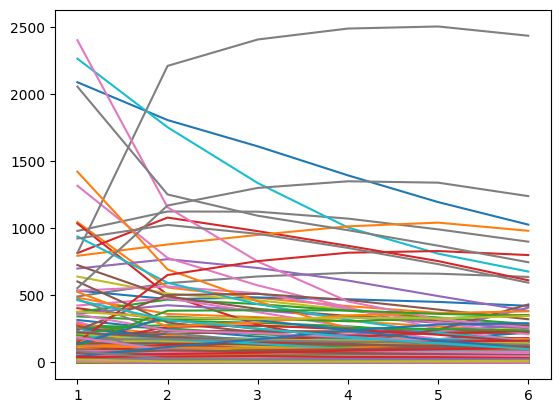

In [9]:
for i in range (2, len(df.columns)):
    plt.plot(df['circle'], df[df.columns[i]])

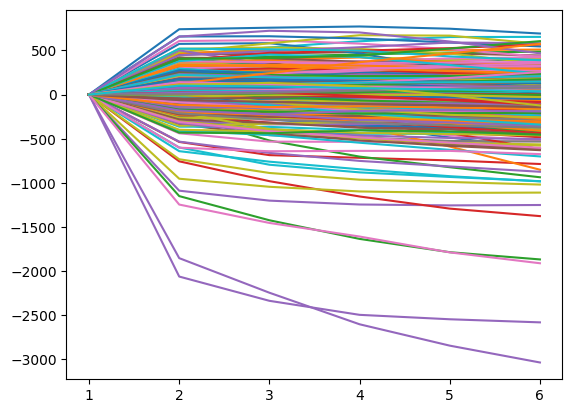

In [36]:
csv3 = f"{directory_path}gal3_numbers_delta2.csv"
df2= pandas.read_csv(csv3)
for i in range (2, len(df2.columns)):
    plt.plot(df2['circle'], df2[df2.columns[i]])

In [45]:
print (len(df2.columns))

In [ ]:
for i in range(len(df)):
    # If the current cell value in the "Slice" column is 1,
    if df['Slice'][i] == 1:
        # Sum the "Total Area" column for the next 10 rows.
        #slice_number = 10  # You need to define slice_number and slice_distance
        #slice_distance = 1  # You need to define slice_number and slice_distance
        bacterial_area = df['Total Area'][i:i + slice_number].sum()
        bacterial_volume = bacterial_area * slice_distance
        # Create a DataFrame with the current pattern number and the total area.
        result_df = pandas.DataFrame({'bacterial_volume': [bacterial_volume]}, index=[i])
        results.append(result_df)

In [10]:
root = tk.Tk()
root.withdraw()
dataset = filedialog.askopenfilename()

In [ ]:
df = pandas.read_csv(dataset)

In [ ]:
norm_raw = []
for i in range(len(df)):
    ratio = df['RawIntDen'][i] / df['Area'][i]
    norm_raw.append(ratio)
df['RawIntDen/Area'] = norm_raw
df.head()

In [ ]:
root = tk.Tk()
root.withdraw()
dataset = filedialog.askopenfilename()

In [6]:
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
w = scyjava.jimport('ij.WindowManager')
for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    imp = ij.IJ.openImage(file_path)
    imp.show()
    imp.setDisplayMode(1)
    imp.setC(1)
    ij.IJ.run(imp, "Grays", "")
    imp.setC(2)
    ij.IJ.run(imp, "Green", "")
    ij.py.run_macro("setMinAndMax(0, 100);")
    imp.setC(3)
    ij.IJ.run(imp, "Blue", "")
    imp.setC(4)
    ij.IJ.run(imp, "Red", "")
    ij.IJ.run(imp, "RGB Color", "slices")
    roi_pattern = os.path.join(bact_roi_path, "*.roi")
    roi_list = glob.glob(roi_pattern)
    for roi in roi_list:
        roi_basename = os.path.basename(roi)
        roi_corename = os.path.splitext(roi_basename)[0]
        open_roi = rm.open(roi)    
        rm.select(0)
        roi = rm.getRoi(0)
        x = roi.getContourCentroid()[0]
        y = roi.getContourCentroid()[1]
        square = imp.setRoi(int(x-20), int(y-20), 40, 40)
        rm.addRoi(square)
        rm.select(1)
        roi2 = rm.getRoi(1)
        square_name = f"{corename}_{roi_corename}"
        ij.IJ.run("Duplicate...", "title="+str(square_name))
        new_vid =  w.getImage(str(square_name))
        output_path = f"{measurement_path}/{square_name}.tif"
        if os.path.exists(output_path):
            os.remove(output_path)
        ij.IJ.save(new_vid, output_path)
        rm.reset()
        ij.IJ.selectWindow(imp.getTitle())
    ij.py.run_macro('close("*");')

[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will b

In [11]:
image = ij.io().open(dataset)
shown = ij.ui().show(image)

[java.lang.Enum.toString] ZeissCZIReader initializing /home/saka/Documents/Lab_stuff/confocal/20230427 thp1lc3 gal3 alix/gal3/Experiment-1549.czi
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"
[java.lang.Enum.toString] [WARN] Unknown DetectorType value 'GaAsP-PMT' will be stored as "Other"


In [7]:
basename = os.path.basename(dataset)
corename = os.path.splitext(basename)[0]
bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
roi_pattern = os.path.join(bact_roi_path, "*.roi")
roi_list = glob.glob(roi_pattern)
for roi in roi_list:
    rm.open(roi)

In [6]:
import sys
import os
import glob
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtCore import *
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *

In [7]:
file_pattern = os.path.join(measurement_path, "*.tif")
file_list = glob.glob(file_pattern)

In [ ]:
class MainWindow(QMainWindow):

    def __init__(self):
        super().__init__()
        self.window()
    
    def window(self):
        self.scroll = QScrollArea()
        self.win = QWidget()
        self.grid = QGridLayout()

        n = 0
        for i in range(30): # number of rows
            for j in range(10): # number of columns
                file = file_list[n] # file_list contains all the image paths
                pixmap = QtGui.QPixmap(file)
                label = QtWidgets.QLabel(pixmap=pixmap)
                self.grid.addWidget(label, i, j)
                n += 1
    
        self.win.setLayout(self.grid)
        self.scroll.setWidgetResizable(True)
        self.scroll.setVerticalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
        self.scroll.setHorizontalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
        self.scroll.setWidget(self.win)
        self.setCentralWidget(self.scroll)
        self.setGeometry(0, 0, 3000, 2000) # window x position, y position, width, height
        self.setWindowTitle('Image Viewer')
        self.show()
        return

def main():
    app = QApplication(sys.argv)
    main = MainWindow()
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()